# Построение рекомендательной системы с помощью векторного представления графа знаний

## 0. Считывание данных

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pandas as pd
import numpy as np
credits=pd.read_csv('tmdb_5000_credits.csv')
movies=pd.read_csv('tmdb_5000_movies.csv')

In [ ]:
credits

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."


In [ ]:
movies

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

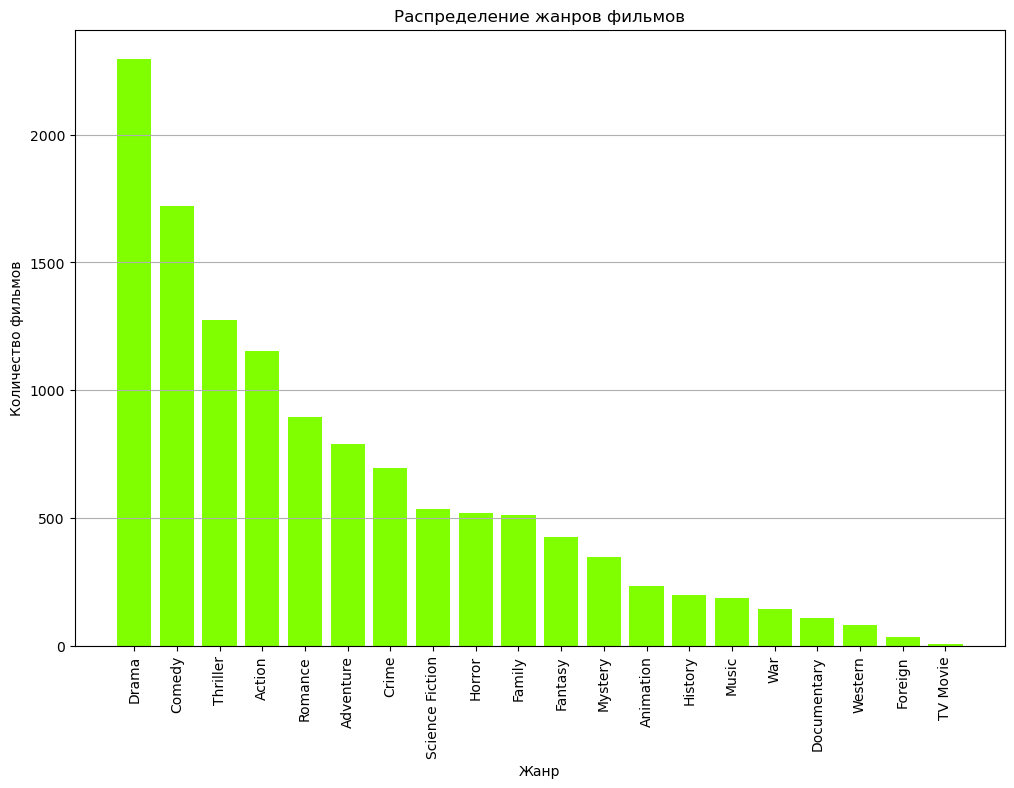

In [ ]:
import ast
import matplotlib.pyplot as plt

# Преобразование строки в список словарей
movies['genres'] = movies['genres'].apply(lambda x: ast.literal_eval(x))

# Подсчет частоты жанров
genres_count = {}
for genre_list in movies['genres']:
    for genre in genre_list:
        if genre['name'] in genres_count:
            genres_count[genre['name']] += 1
        else:
            genres_count[genre['name']] = 1

# Создание датафрейма для построения графика
genres_df = pd.DataFrame(list(genres_count.items()), columns=['Жанр', 'Количество фильмов'])

# Сортировка по количеству фильмов
genres_df = genres_df.sort_values(by='Количество фильмов', ascending=False)
plt.figure(figsize=(12, 8))
plt.bar(genres_df['Жанр'], genres_df['Количество фильмов'], color='chartreuse')
plt.title('Распределение жанров фильмов')
plt.xlabel('Жанр')
plt.ylabel('Количество фильмов')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.show()


In [ ]:
movies['popularity'].max()

875.581305

In [ ]:
credits_info = credits.info()
movies_info = movies.info()

credits_head = credits.head()
movies_head = movies.head()

credits_info, movies_info, credits_head, movies_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   objec

(None,
 None,
    movie_id                                     title  \
 0     19995                                    Avatar   
 1       285  Pirates of the Caribbean: At World's End   
 2    206647                                   Spectre   
 3     49026                     The Dark Knight Rises   
 4     49529                               John Carter   
 
                                                 cast  \
 0  [{"cast_id": 242, "character": "Jake Sully", "...   
 1  [{"cast_id": 4, "character": "Captain Jack Spa...   
 2  [{"cast_id": 1, "character": "James Bond", "cr...   
 3  [{"cast_id": 2, "character": "Bruce Wayne / Ba...   
 4  [{"cast_id": 5, "character": "John Carter", "c...   
 
                                                 crew  
 0  [{"credit_id": "52fe48009251416c750aca23", "de...  
 1  [{"credit_id": "52fe4232c3a36847f800b579", "de...  
 2  [{"credit_id": "54805967c3a36829b5002c41", "de...  
 3  [{"credit_id": "52fe4781c3a36847f81398c3", "de...  
 4  [{"credi

### Первый датасет: "TMDB 5000 Movie Dataset"

Данный датасет содержит информацию о фильмах из базы данных The Movie Database (TMDb). Он включает в себя метаданные о более чем 5000 фильмах, включая сведения о сюжете, актерском составе, съемочной группе, бюджете и доходах. Датасет содержит два файла:
* tmdb_5000_credits.csv: Содержит информацию о фильмах, включая идентификатор фильма, название, информацию о составе актеров и съемочной группе.
*
tmdb_5000_movies.csv: Содержит информацию о фильмах, такую как бюджет, жанры, дата выхода, доходы и т. д

Датасет содержит в себе 9606 строк и 24 колонки..

### Второй датасет: "The Movies Dataset"

Данный датасет содержит метаданные о более чем 45 000 фильмах из полного датасета MovieLens, включая информацию о съемочной группе, ключевых словах сюжета, бюджете, доходах, датах выхода, языках, странах производства и компаниях. В дополнение, в датасете имеются файлы, содержащие 26 миллионов рейтингов от 270 000 пользователей для всех 45 000 фильмов.
Датасет включает в себя несколько файлов:
* movies_metadata.csv: Главный файл метаданных о фильмах. Содержит информацию о постерах, бюджете, доходах, датах выхода, языках, странах производства и компаниях.
*
keywords.csv: Содержит ключевые слова сюжета для фильмов
*
credits.csv: Содержит информацию о составе актеров и съемочной группе для всех фильмо
* .
links.csv: Содержит идентификаторы фильмов из баз данных TMDB и IM
* B.
links_small.csv: Содержит идентификаторы TMDB и IMDB небольшого подмножества из 9000 филь
* ов.
ratings_small.csv: Подмножество из 100 000 рейтингов от 700 пользователей для 9000 фил

В данной работе используется файл ratings_small.csv для построения рекомендательной системы.ьмов.

## 1. Исследование и предобработка данных.

Сначала исследуем данные, чтобы понять их структуру и определить, какие данные могут быть использованы для построения графа знаний.

In [ ]:
credits.columns = ['id','tittle','cast','crew']
movies= movies.merge(credits,on='id')
movies.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


*Demographic Filtering*

Прежде чем приступить к работе с этим - нам нужен показатель для оценки фильма:
1) Рассчитать оценку для каждого фильма
2) Отсортировать оценки и рекомендации пользователям фильм с самым высоким рейтингом.
3) Использование средние оценки фильма в качестве оценки, но это будет недостаточно справедливо, поскольку фильм со средним рейтингом 8,9 и всего 3 голосами не может считаться лучшим, чем фильм со средним рейтингом 7,8, но 40 голосами. Итак, я буду использовать взвешенный рейтинг IMDB (wr), который представлен следующим образом где,

vote_average - количество голосов, отданных за фильм;
vote_count - минимальное количество голосов, которое должно быть указано в таблице;
R - средний рейтинг фильма;И
C - среднее количество голосов по всему отчетуcalculated as

In [ ]:
vote_average= movies['vote_average'].mean()
vote_average

6.092171559442016

Таким образом, средний рейтинг всех фильмов составляет приблизительно 6 баллов по десятибалльной шкале.Следующим шагом является определение подходящего значения для m, минимального количества голосов, которое должно быть указано в таблице. Будет использовать 90-й процентиль в качестве критерия. Другими словами, чтобы фильм попал в чарты, он должен набрать больше голосов, чем как минимум 90% фильмов из списка.

In [ ]:
vote_count= movies['vote_count'].quantile(0.9)
vote_count

1838.4000000000015

Теперь можно отфильтровать фильмы, которые попадают в этот чарт

In [ ]:
q_movies = movies.copy().loc[movies['vote_count'] >= vote_count]
q_movies.shape

(481, 23)

Мы видим, что в этом списке 481 фильм, которые могут быть включены в этот список. Теперь нам нужно рассчитать наш показатель для каждого подходящего фильма. Чтобы сделать это, мы определим функцию rating() и определим новую оценку полнометражных фильмов, значение которой мы вычислим, применив эту функцию к нашему кадру данных о квалифицированных фильмах.

In [ ]:
def ratings(x, m=vote_count, C=vote_average):
    v = x['vote_count']
    R = x['vote_average']
    # Расчет по формуле IMDB
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
q_movies['score'] = q_movies.apply(ratings, axis=1)

In [ ]:
#Сортировка фильмов на основе оценки, рассчитанной выше
q_movies = q_movies.sort_values('score', ascending=False)
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Подготовка первой и простой рекомендации, без графа.

Text(0.5, 1.0, 'Популярные фильмы')

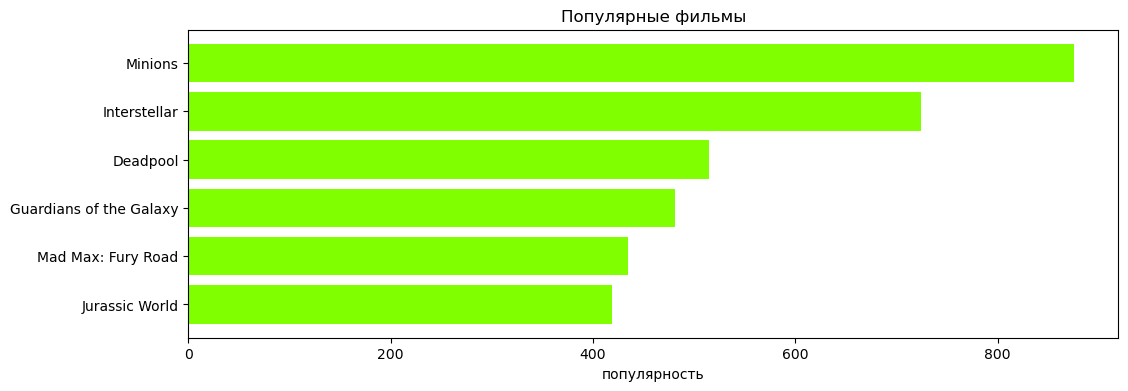

In [ ]:
import matplotlib.pyplot as plt

popular_plt= movies.sort_values('popularity', ascending=False)
plt.figure(figsize=(12,4))

plt.barh(popular_plt['title'].head(6),popular_plt['popularity'].head(6), align='center',
        color='chartreuse')
plt.gca().invert_yaxis()
plt.xlabel("популярность")
plt.title("Популярные фильмы")

## 2. Построение графа знаний.

На основе исследования данных будет создан граф знаний, который будет представлять отношения между различными сущностями датасете (например, фильмы, актеры, жанры).

In [ ]:
movies['overview'].head(5)

0    In the 22nd century, a paraplegic Marine is di...
1    Captain Barbossa, long believed to be dead, ha...
2    A cryptic message from Bond’s past sends him o...
3    Following the death of District Attorney Harve...
4    John Carter is a war-weary, former military ca...
Name: overview, dtype: object

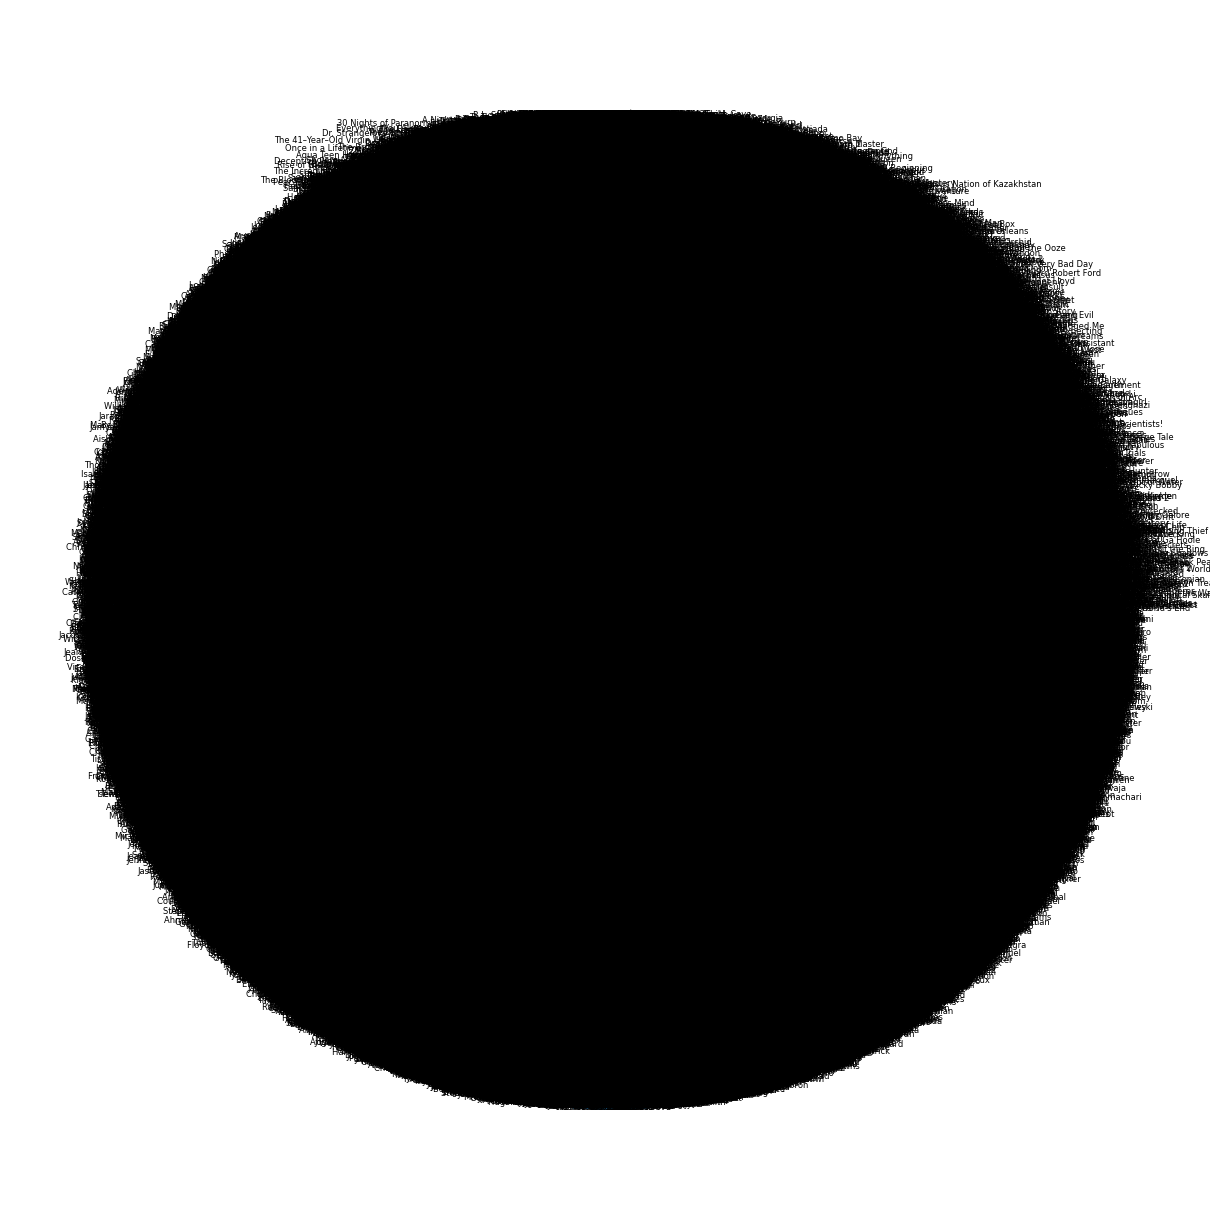

In [ ]:
import json
import networkx as nx
import ast
G = nx.Graph()

# Добавление узлов и рёбер для жанров
for i, row in movies.iterrows():
    G.add_node(row['title'], type='Movie', id=row['id'])
    genres = json.loads(row['genres'].replace("'", '"'))
    for genre in genres:
        genre_name = genre['name']
        if not G.has_node(genre_name):
            G.add_node(genre_name, type='Genre')
        G.add_edge(row['title'], genre_name)

# Добавление узлов и рёбер для актёров
for i, row in movies.iterrows():
    try:
        cast = ast.literal_eval(row['cast'])
    except ValueError as e:
        print(f"Ошибка при обработке строки для фильма {row['title']}: {e}")
        continue
    for actor in cast[:5]:  # Ограничимся первыми 5 актёрами для простоты
        actor_name = actor['name']
        if not G.has_node(actor_name):
            G.add_node(actor_name, type='Actor')
        G.add_edge(row['title'], actor_name)
plt.figure(figsize=(12,12))
pos = nx.circular_layout(G)
nx.draw(G, pos, with_labels=True, node_size=10, font_size=6)
plt.show()

In [ ]:
for node, attrs in list(G.nodes(data=True))[:5]:
    print(f"Узел: {node}, Атрибуты: {attrs}")

Узел: Avatar, Атрибуты: {'type': 'Movie', 'id': 19995}
Узел: Action, Атрибуты: {'type': 'Genre'}
Узел: Adventure, Атрибуты: {'type': 'Genre'}
Узел: Fantasy, Атрибуты: {'type': 'Genre'}
Узел: Science Fiction, Атрибуты: {'type': 'Genre'}


In [ ]:
print("Количество узлов в графе:", G.number_of_nodes())
print("Количество связей в графе:", G.number_of_edges())

Количество узлов в графе: 14207
Количество связей в графе: 35747


## 3. Векторное представление графа

 Используя алгоритмы векторизации графов, преобразуем граф знаний в векторное представление, которое можно будет использовать для обучения рекомендательной модели.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

#Удалит все английские стоп-слова, такие как "the", "a"
tfidf = TfidfVectorizer(stop_words='english')

#удаление пустых значений
movies['overview'] = movies['overview'].fillna('')

#Построение матрицы TF-IDF путем подгонки и преобразования данных
tfidf_matrix = tfidf.fit_transform(movies['overview'])
tfidf_matrix.shape

(4803, 20978)

Мы видим, что для описания 4800 фильмов в нашем наборе данных было использовано более 20 000 различных слов.
Теперь, имея в руках эту матрицу, мы можем рассчитать степень сходства. Для этого есть несколько вариантов, таких как евклидова оценка подобия, оценка Пирсона и оценка косинусоидального сходства.
Мы будем использовать косинусоидальное сходство для вычисления числовой величины, которая обозначает сходство между двумя фильмами. Мы используем показатель косинусоидального сходства, поскольку он не зависит от величины и его относительно легко и быстро вычислить. Математически он определяется как полный
ows:

In [ ]:
from sklearn.metrics.pairwise import linear_kernel
# Матрица косинусоидального подобия
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

Определяем функцию, которая принимает название фильма в качестве входных данных и выдает список из 10 наиболее похожих фильмов. Во-первых, для этого нам нужно обратное сопоставление названий фильмов и индексов фреймов данных. Другими словами, нам нужен механизм для определения индекса фильма в нашем фрейме данных метаданных, учитывая его название.

In [ ]:
# Обратная карта индексов для фильмов, удаление дубликатов
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

In [ ]:
import networkx as nx
from node2vec import Node2Vec

# Генерация эмбеддингов узлов с использованием Node2Vec
node2vec = Node2Vec(G, dimensions=100, walk_length=16, num_walks=100, workers=2)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
# Получение вектора для фильма (или любого узла) из графа
vector = model.wv['Avatar']

Computing transition probabilities:   0%|          | 0/14207 [00:00<?, ?it/s]

In [ ]:
# Сбор списка названий фильмов из графа
list_of_films = [node for node, attrs in G.nodes(data=True) if attrs.get('type') == 'Movie']
list_of_films = list(G.nodes())

In [ ]:
# Расчёт сходства между фильмами на основе эмбеддингов
from sklearn.metrics.pairwise import cosine_similarity
film_vectors = np.array([model.wv[film] for film in list_of_films])
# Расчёт матрицы косинусного сходства
cosine_sim_graph = cosine_similarity(film_vectors, film_vectors)

In [ ]:
cosine_sim_graph

array([[0.99999994, 0.41464093, 0.42080167, ..., 0.12423368, 0.09163986,
        0.131619  ],
       [0.41464093, 1.        , 0.45588577, ..., 0.3437158 , 0.36457205,
        0.197166  ],
       [0.42080167, 0.45588577, 1.        , ..., 0.19455476, 0.25428957,
        0.24061619],
       ...,
       [0.12423368, 0.3437158 , 0.19455476, ..., 1.0000001 , 0.92758596,
        0.13010949],
       [0.09163986, 0.36457205, 0.25428957, ..., 0.92758596, 1.        ,
        0.14956295],
       [0.131619  , 0.197166  , 0.24061619, ..., 0.13010949, 0.14956295,
        0.9999999 ]], dtype=float32)

Все необходимые подготовки к построению рекомендательной системы завершены, теперь получим индекс фильма с учетом его названия, получим список показателей косинусного сходства для этого конкретного фильма со всеми фильмами. преобразуем его в список кортежей, где первый элемент - это позиция, а второй - показатель сходства, отсортируем вышеупомянутый список кортежей на основе показателей сходства, то есть второго элемента.
Но для использования векторного представления графа будем использовать несколько иной подход, сопоставляя связи графа с индексами фильмов для рекомендацией. Составим два подхода - без учета графа и с ним для сравнения.

## 4. Разработка рекомендательной модели

На основе векторных представлений мы разработаем и обучим рекомендательную модель, которая будет предсказывать потенциальный интерес пользователя к фильмам.

**Content Based Filtering** -  это рекомендация на основе содержимого, которое пытается предсказать, понравится ли пользователю некоторый продукт, используя его онлайновую историю.

In [ ]:
movies['title']

0                                         Avatar
1       Pirates of the Caribbean: At World's End
2                                        Spectre
3                          The Dark Knight Rises
4                                    John Carter
                          ...                   
4798                                 El Mariachi
4799                                   Newlyweds
4800                   Signed, Sealed, Delivered
4801                            Shanghai Calling
4802                           My Date with Drew
Name: title, Length: 4803, dtype: object

In [ ]:
# Создание словаря индексов
indices = pd.Series(index=movies['title'], data=range(len(movies))).to_dict()
indices

{'Avatar': 0,
 "Pirates of the Caribbean: At World's End": 1,
 'Spectre': 2,
 'The Dark Knight Rises': 3,
 'John Carter': 4,
 'Spider-Man 3': 5,
 'Tangled': 6,
 'Avengers: Age of Ultron': 7,
 'Harry Potter and the Half-Blood Prince': 8,
 'Batman v Superman: Dawn of Justice': 9,
 'Superman Returns': 10,
 'Quantum of Solace': 11,
 "Pirates of the Caribbean: Dead Man's Chest": 12,
 'The Lone Ranger': 13,
 'Man of Steel': 14,
 'The Chronicles of Narnia: Prince Caspian': 15,
 'The Avengers': 16,
 'Pirates of the Caribbean: On Stranger Tides': 17,
 'Men in Black 3': 18,
 'The Hobbit: The Battle of the Five Armies': 19,
 'The Amazing Spider-Man': 20,
 'Robin Hood': 21,
 'The Hobbit: The Desolation of Smaug': 22,
 'The Golden Compass': 23,
 'King Kong': 24,
 'Titanic': 25,
 'Captain America: Civil War': 26,
 'Battleship': 27,
 'Jurassic World': 28,
 'Skyfall': 29,
 'Spider-Man 2': 30,
 'Iron Man 3': 31,
 'Alice in Wonderland': 32,
 'X-Men: The Last Stand': 33,
 'Monsters University': 34,
 'Tra

In [ ]:
# Функция рекомендации, модифицированная для использования графовых эмбеддингов
def get_recommendations_with_graph(title):
    if title in list_of_films:
        # Получаем индекс фильма из списка фильмов, который синхронизирован с cosine_sim_graph
        idx = list_of_films.index(title)

        # Получаем сходство для этого фильма со всеми другими
        sim_scores = list(enumerate(cosine_sim_graph[idx]))

        # Сортируем фильмы на основе сходства
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Получаем индексы 10 самых похожих фильмов
        sim_scores = sim_scores[1:11]  # Исключаем сам фильм из списка

        # Получаем названия фильмов, используя их индексы в list_of_films
        movie_indices = [i[0] for i in sim_scores]
        recommended_titles = [list_of_films[i] for i in movie_indices]

        return recommended_titles
    else:
        return "Фильм не найден."
get_recommendations_with_graph('Avatar')

['Stephen Lang',
 'Sam Worthington',
 'Michelle Rodriguez',
 'Zoe Saldana',
 'Sigourney Weaver',
 'Shadow Conspiracy',
 'Backmask',
 'Guardians of the Galaxy',
 'The Nut Job',
 'Star Trek Into Darkness']

In [ ]:
get_recommendations_with_graph('Jurassic World')

['Nick Robinson',
 'Irrfan Khan',
 'Bryce Dallas Howard',
 'Chris Pratt',
 'Life of Pi',
 'The 5th Wave',
 "Vincent D'Onofrio",
 'Alex Roe',
 'Gautam Belur',
 'Adil Hussain']

**---**

In [ ]:
def get_recommendations_no_graph(title, cosine_sim=cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices]

In [ ]:
get_recommendations_no_graph('Avatar')

3604                       Apollo 18
2130                    The American
634                       The Matrix
1341            The Inhabited Island
529                 Tears of the Sun
1610                           Hanna
311     The Adventures of Pluto Nash
847                         Semi-Pro
775                        Supernova
2628             Blood and Chocolate
Name: title, dtype: object

In [ ]:
get_recommendations_no_graph('Jurassic World')

508     The Lost World: Jurassic Park
675                     Jurassic Park
2527      National Lampoon's Vacation
1580                      The Nut Job
1536                         Vacation
1983                 Meet the Deedles
3139                    Adventureland
3577                 The Way Way Back
1402                     Black Knight
414                        Scooby-Doo
Name: title, dtype: object

На самом деле сравнить их оказалось куда сложнее, так как фильмы просмотрены не были. но если судить сугубо по названиям, можно сказать, что подход без учета графа показал результаты больше отражающие реальность.

**Credits, Genres and Keywords Based Recommender** - это рекомендации на основе наименований, жанров и ключевых слов.

In [ ]:
# Парсинг структурированные объекты в соответствующие им объекты python
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(literal_eval)

In [ ]:
# Узнаем имя режиссера в разделе "Съемочная группа". Если режиссера нет в списке, возвращаем NAN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
# Возвращает 3 верхних элемента списка или весь список целиком; в зависимости от того, что больше.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Проверка, существует ли более 3 элементов. Если да, возврат только первые три. Если нет, возврат весь список.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [ ]:
# Определение нового режиссера, актерский состав, жанры и ключевые слова, которые будут представлены в подходящей форме.
movies['director'] = movies['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(get_list)

In [ ]:
movies[['title', 'cast', 'director', 'keywords', 'genres']].head(5)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"
3,The Dark Knight Rises,"[Christian Bale, Michael Caine, Gary Oldman]",Christopher Nolan,"[dc comics, crime fighter, terrorist]","[Action, Crime, Drama]"
4,John Carter,"[Taylor Kitsch, Lynn Collins, Samantha Morton]",Andrew Stanton,"[based on novel, mars, medallion]","[Action, Adventure, Science Fiction]"


In [ ]:
# Функция для преобразования всех строк в нижний регистр и удаления пробелов из имен
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [ ]:
#применяем очистку данных
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    movies[feature] = movies[feature].apply(clean_data)

In [ ]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
movies['soup'] = movies.apply(create_soup, axis=1)

теперь аналогично векторизуем признаки

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies['soup'])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [ ]:
#обновляем индексы
movies = movies.reset_index()
indices = pd.Series(movies.index, index=movies['title'])

In [ ]:
get_recommendations_no_graph('Avatar', cosine_sim2)

206                         Clash of the Titans
71        The Mummy: Tomb of the Dragon Emperor
786                           The Monkey King 2
103                   The Sorcerer's Apprentice
131                                     G-Force
215      Fantastic 4: Rise of the Silver Surfer
466                            The Time Machine
715                           The Scorpion King
1      Pirates of the Caribbean: At World's End
5                                  Spider-Man 3
Name: title, dtype: object

In [ ]:
get_recommendations_no_graph('Jurassic World', cosine_sim2)

94            Guardians of the Galaxy
508     The Lost World: Jurassic Park
1079                             Dune
4401              The Helix... Loaded
83                         The Lovers
193                       After Earth
4117               Six-String Samurai
91       Independence Day: Resurgence
101                X-Men: First Class
466                  The Time Machine
Name: title, dtype: object

Можно увидеть, что рекомендации без учета были довольно успешны, и названия так же сходятся. Хотя по признакам сложно заметить, насколько точен алгоритм

In [ ]:
def get_recommendations_graph(title, cosine_sim=cosine_sim_graph):
    if title in list_of_films:
        idx = list_of_films.index(title)
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:11]
        movie_indices = [i[0] for i in sim_scores]
        recommended_titles_graph = [list_of_films[i] for i in movie_indices]
        return recommended_titles_graph
    else:
        return "Фильм не найден."
get_recommendations_with_graph('Avatar')

['Stephen Lang',
 'Sam Worthington',
 'Michelle Rodriguez',
 'Zoe Saldana',
 'Sigourney Weaver',
 'Shadow Conspiracy',
 'Backmask',
 'Guardians of the Galaxy',
 'The Nut Job',
 'Star Trek Into Darkness']

In [ ]:
get_recommendations_with_graph('Jurassic World')

['Nick Robinson',
 'Irrfan Khan',
 'Bryce Dallas Howard',
 'Chris Pratt',
 'Life of Pi',
 'The 5th Wave',
 "Vincent D'Onofrio",
 'Alex Roe',
 'Gautam Belur',
 'Adil Hussain']

Судя по названиям, алгоритм с учетом графов так же странно рекомендует фильмы. В дальнейшем, можно будет улучшить качество отбора признаков для вершин и ребер графа, чтобы увеличить точность рекомендационной выборки

In [ ]:
def get_recommendations_content(title, cosine_sim=cosine_sim2):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movies['title'].iloc[movie_indices].tolist()
get_recommendations_content('Avatar')

['Clash of the Titans',
 'The Mummy: Tomb of the Dragon Emperor',
 'The Monkey King 2',
 "The Sorcerer's Apprentice",
 'G-Force',
 'Fantastic 4: Rise of the Silver Surfer',
 'The Time Machine',
 'The Scorpion King',
 "Pirates of the Caribbean: At World's End",
 'Spider-Man 3']

In [ ]:
get_recommendations_content('Jurassic World')

['Guardians of the Galaxy',
 'The Lost World: Jurassic Park',
 'Dune',
 'The Helix... Loaded',
 'The Lovers',
 'After Earth',
 'Six-String Samurai',
 'Independence Day: Resurgence',
 'X-Men: First Class',
 'The Time Machine']

In [ ]:
def combined_recommendations(title):
    recs_graph = get_recommendations_graph(title)
    recs_content = get_recommendations_content(title)
    if isinstance(recs_graph, str):
        return "Фильм не найден."
    combined_recs = list(set(recs_graph + recs_content))  # Объединяем и удаляем дубликаты
    return combined_recs[:10]

title = 'Avatar'
combined_recs = combined_recommendations(title)
print(f"Комбинированные рекомендации для фильма {title}: \n", combined_recs)


Комбинированные рекомендации для фильма Avatar: 
 ['Shadow Conspiracy', "Pirates of the Caribbean: At World's End", 'Michelle Rodriguez', 'Sigourney Weaver', 'Star Trek Into Darkness', 'The Mummy: Tomb of the Dragon Emperor', 'Fantastic 4: Rise of the Silver Surfer', 'The Scorpion King', 'Stephen Lang', 'Zoe Saldana']


In [ ]:
title = 'Jurassic World'
combined_recs = combined_recommendations(title)
print(f"Комбинированные рекомендации для фильма {title}: \n", combined_recs)

Комбинированные рекомендации для фильма Jurassic World: 
 ['The Lovers', 'Independence Day: Resurgence', 'Irrfan Khan', "Vincent D'Onofrio", 'Alex Roe', 'The Lost World: Jurassic Park', 'Chris Pratt', 'Dune', 'Life of Pi', 'Nick Robinson']


Тестирование комбинации рекомендацией с учетом обычных текстовых эмбеддингов и графа. В целом, названия стали явно лучше, как будто бы даже имеют смысловое сходство, по крайней мере в рамках жанра

**Collaborative Filtering** - технология прогнозирования предпочтений пользователя с учетом интересов других посетителей интернет-ресурса.

В данном случае используем библиотеку surprise, которая имеет вшитый ии, и в качестве движка использует С++ibrary to implement SVD.

In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
import pandas as pd

# Загрузка данных
reader = Reader()
ratings = pd.read_csv('ratings_small.csv')
ratings

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
...,...,...,...,...
99999,671,6268,2.5,1065579370
100000,671,6269,4.0,1065149201
100001,671,6365,4.0,1070940363
100002,671,6385,2.5,1070979663


In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
# алгоритм SVD
algo = SVD()

# Оценка производительности алгоритма
results = cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

print(results)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8943  0.8900  0.8937  0.9027  0.9008  0.8963  0.0047  
MAE (testset)     0.6883  0.6840  0.6912  0.6947  0.6927  0.6902  0.0038  
Fit time          0.77    0.65    0.73    0.75    0.80    0.74    0.05    
Test time         0.11    0.12    0.11    0.12    0.12    0.12    0.00    
{'test_rmse': array([0.89425245, 0.88998407, 0.89367526, 0.9026523 , 0.90075208]), 'test_mae': array([0.68830211, 0.68396064, 0.69115248, 0.69473282, 0.69273718]), 'fit_time': (0.7700855731964111, 0.6471178531646729, 0.7344012260437012, 0.7455878257751465, 0.7953393459320068), 'test_time': (0.11413073539733887, 0.11881327629089355, 0.1131293773651123, 0.11924004554748535, 0.12010765075683594)}


In [ ]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [ ]:
ratings[ratings['userId'] == 1]

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [ ]:
algo.predict(300, 300, 300)

Prediction(uid=300, iid=300, r_ui=300, est=4.1752958191931, details={'was_impossible': False})

Для фильма с идентификатором 300 мы получаем приблизительный прогноз в 4.1752958191931. Одна из поразительных особенностей этой системы рекомендаций заключается в том, что ей все равно, что это за фильм (или что в нем содержится). Он работает исключительно на основе присвоенного идентификатора фильма и пытается предсказать рейтинги на основе того, как другие пользователи оценили фильм.

Теперь попробуем добавить в эту систему вывод списка рекомендаций названий фильмов, а так же графовый метод для уточняющего алгоритма рекомендационной системы

In [ ]:
def get_movie_title(movie_id):
    title = movies[movies['id'] == movie_id]['title'].values[0]
    return title if title else None

# Получение рекомендаций для конкретного пользователя
def get_svd_recommendations(user_id, n=10):
    all_movies = list(movies['id'])
    # Предсказываем рейтинги для всех фильмов
    predictions = [algo.predict(user_id, movie_id) for movie_id in all_movies]
    # Сортируем предсказания по убыванию предсказанного рейтинга
    predictions.sort(key=lambda x: x.est, reverse=True)
    # Получаем топ-N рекомендаций
    top_n_recommendations = predictions[:n]
    # Преобразуем ID фильмов в их названия
    top_n_movie_titles = [get_movie_title(pred.iid) for pred in top_n_recommendations]
    return top_n_movie_titles

# Использование графовых эмбеддингов для уточнения рекомендаций
def refine_recommendations_with_graph_embeddings(original_recommendations):
    # Получаем эмбеддинги для рекомендованных фильмов
    recommended_movie_embeddings = np.array([model.wv[title] for title in original_recommendations if title in model.wv])
    user_preference_embedding = np.mean(recommended_movie_embeddings, axis=0)
    # Рассчитываем косинусное сходство между предпочтениями пользователя и всеми фильмами
    similarity_scores = cosine_similarity([user_preference_embedding], film_vectors)[0]
    # Сортируем фильмы на основе сходства
    sorted_indices = np.argsort(similarity_scores)[::-1]
    # Получаем отсортированный список рекомендаций
    sorted_recommendations = [list_of_films[i] for i in sorted_indices if list_of_films[i] in original_recommendations]
    return sorted_recommendations

user_id = 1  # ID пользователя
original_recommendations = get_svd_recommendations(user_id)
refined_recommendations = refine_recommendations_with_graph_embeddings(original_recommendations)

print("Оригинальные рекомендации:", original_recommendations)
print("Уточнённые рекомендации:", refined_recommendations)


Оригинальные рекомендации: ["Pandora's Box", 'Galaxy Quest', 'The Thomas Crown Affair', 'The Talented Mr. Ripley', 'The Good Thief', 'Cars', 'The Sixth Sense', 'Beverly Hills Cop III', 'Solaris', 'Edward Scissorhands']
Уточнённые рекомендации: ["Pandora's Box", 'The Good Thief', 'Galaxy Quest', 'Cars', 'The Sixth Sense', 'Beverly Hills Cop III', 'The Thomas Crown Affair', 'Solaris', 'Edward Scissorhands', 'The Talented Mr. Ripley']


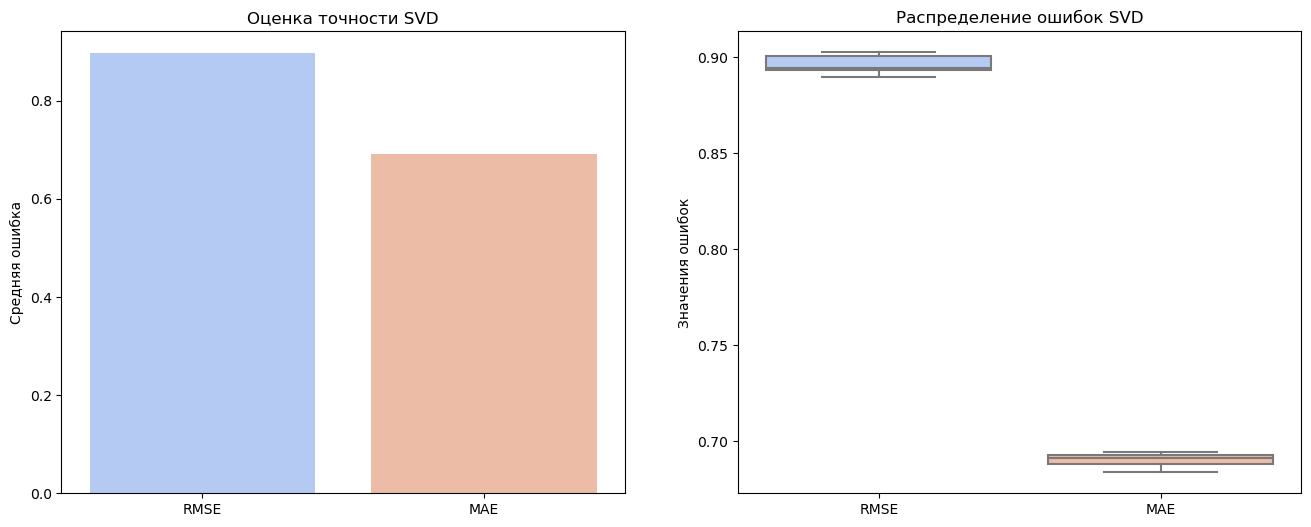

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Визуализация RMSE и MAE
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=['RMSE', 'MAE'], y=[np.mean(results['test_rmse']), np.mean(results['test_mae'])], ax=ax[0], palette='coolwarm')
ax[0].set_title('Оценка точности SVD')
ax[0].set_ylabel('Средняя ошибка')

sns.boxplot(data=[results['test_rmse'], results['test_mae']], ax=ax[1], palette='coolwarm')
ax[1].set_title('Распределение ошибок SVD')
ax[1].set_xticklabels(['RMSE', 'MAE'])
ax[1].set_ylabel('Значения ошибок')
plt.show()

Как видно, система с учетом графа подкорректировала рекомендации, что означает, что векторизированные представления графов выполнили свою работу в рекомендационной системе.

# ВЫВОД
В рамках проделанной работы было рассмотрено несколько подходов к построению системы рекомендаций:

Content-Based Filteri - : Система рекомендаций, основанная на содержании (контенте), использует информацию о фильмах, такую как жанры, описание и ключевые слова, для вычисления сходства между фильмами и генерации рекомендаций. Для этого использовались TF-IDF векторизация и косинусное сходство.

Graph-Based Recommendat - ns: Применение графовых эмбеддингов, сгенерированных с помощью Node2Vec на основе графа, включающего фильмы, жанры и актеров, для создания векторных представлений фильмов. Эти эмбеддинги использовались для улучшения рекомендаций за счет учета структурных связей между элементами контента.

Collaborative Fil - ring: Использование модели SVD для коллаборативной фильтрации, основанной на рейтингах пользователей, для предсказания оценок, которые пользователь может поставить неизвестным фильмам, и формирования на их основе рекомендаций.

В ходе работы были рассмотрены методы уточнения рекомендаций с использованием графовых эмб (векторного представления графа знаний)еддингов и комбинирования различных подходов для повышения качества и релевантности рекомзе графов.

# GNN

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
movies = pd.read_csv('movie.csv')
ratings = pd.read_csv('rating.csv')
df = pd.merge(movies, ratings, how="inner", on="movieId")
label_encoder = LabelEncoder()
df['userId'] = label_encoder.fit_transform(df['userId'])
df['movieId'] = label_encoder.fit_transform(df['movieId'])
df['genres'] = label_encoder.fit_transform(df['genres'])


train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)
train_data

,movieId,title,genres,userId,rating,timestamp
7253497,1263,Indiana Jones and the Last Crusade (1989),2,7959,5.0,1997-05-25 09:38:08
14109136,3902,"Crouching Tiger, Hidden Dragon (Wo hu cang lon...",385,32454,4.0,2008-03-04 15:09:54
556806,46,Seven (a.k.a. Se7en) (1995),1307,98382,2.0,1996-10-30 08:41:27
5763882,1068,Platoon (1986),1226,84030,4.0,2001-06-29 08:41:18
5575155,1037,Everyone Says I Love You (1996),1003,51099,4.0,2000-11-27 22:11:33
...,...,...,...,...,...,...
9628519,1975,"Parent Trap, The (1998)",845,100158,3.0,1999-10-10 02:12:18
14586186,4211,Shrek (2001),479,54270,4.0,2008-03-18 10:21:50
2234489,325,Star Trek: Generations (1994),664,95543,3.0,2000-02-06 00:21:01
13315092,3437,Predator (1987),454,15681,5.0,2002-10-02 23:09:35


In [ ]:
max_movie_id = movie_ids.max().item()
num_users = train_data['userId'].nunique()
print("Max movie ID:", max_movie_id, "Number of users:", num_users)

Max movie ID: 165236 Number of users: 138493


In [ ]:
import torch
from torch_geometric.data import Data

# сопоставление ID пользователей и фильмов к узлам в графе
user_ids = torch.tensor(train_data['userId'].values, dtype=torch.long)
movie_ids = torch.tensor(train_data['movieId'].values, dtype=torch.long) + train_data['userId'].nunique()  # Смещаем ID фильмов

# создание рёбер
edge_index = torch.stack([user_ids, movie_ids], dim=0)

# веса рёбер
edge_attr = torch.tensor(train_data['rating'].values, dtype=torch.float)

graph_data = Data(edge_index=edge_index, edge_attr=edge_attr)
graph_data

Data(edge_index=[2, 16000210], edge_attr=[16000210])

In [ ]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GraphRecNN(nn.Module):
    def __init__(self, num_users, num_movies, num_features, hidden_size=64):
        super(GraphRecNN, self).__init__()
        self.user_emb = nn.Embedding(num_users, num_features)
        self.movie_emb = nn.Embedding(num_movies, num_features)

        # свёрточные
        self.conv1 = GCNConv(num_features, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)

        # полносвязные
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, data):
        x = torch.cat([self.user_emb.weight, self.movie_emb.weight], dim=0)
        edge_index = data.edge_index

        # графовые
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))

        # агрегация
        src, dst = edge_index
        x = torch.cat([x[src], x[dst]], dim=1)

        # полносвязные
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()

In [ ]:
num_users = train_data['userId'].nunique()
num_movies = train_data['movieId'].nunique()

# cмещение movie_ids должно начинаться после последнего userId
corrected_movie_ids = torch.tensor(train_data['movieId'].values, dtype=torch.long) + num_users

max_corrected_movie_id = corrected_movie_ids.max().item()
total_nodes = num_users + num_movies

print("Исправленый максимальный id фильма:", max_corrected_movie_id)
print("Общее количество узлов:", total_nodes)

edge_index = torch.stack([torch.tensor(train_data['userId'].values, dtype=torch.long), corrected_movie_ids], dim=0)

model = GraphRecNN(total_nodes, total_nodes, num_features)

if max_corrected_movie_id >= total_nodes:
    total_nodes = max_corrected_movie_id + 1
    print("Обновленное кол-во узлов:", total_nodes)
    model = GraphRecNN(total_nodes, total_nodes, num_features)
    graph_data = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=total_nodes)
else:
    print("Общее количество узлов:", total_nodes)
graph_data = Data(edge_index=edge_index, edge_attr=edge_attr, num_nodes=total_nodes)

Исправленый максимальный id фильма: 165236
Общее количество узлов: 164350
Обновленное кол-во узлов: 165237


Эпоха 1, Потери обучения: 1.3491, Тестовые потери: 2.1267
Эпоха 2, Потери обучения: 1.4915, Тестовые потери: 2.4374
Эпоха 3, Потери обучения: 1.3650, Тестовые потери: 2.7826
Эпоха 4, Потери обучения: 1.3390, Тестовые потери: 2.9419
Эпоха 5, Потери обучения: 1.3977, Тестовые потери: 2.9312
Эпоха 6, Потери обучения: 1.3751, Тестовые потери: 2.8111
Эпоха 7, Потери обучения: 1.3577, Тестовые потери: 2.6367
Эпоха 8, Потери обучения: 1.3331, Тестовые потери: 2.5410
Эпоха 9, Потери обучения: 1.3481, Тестовые потери: 2.4618
Эпоха 10, Потери обучения: 1.3404, Тестовые потери: 2.4262
Эпоха 11, Потери обучения: 1.3532, Тестовые потери: 2.4156
Эпоха 12, Потери обучения: 1.3430, Тестовые потери: 2.4149


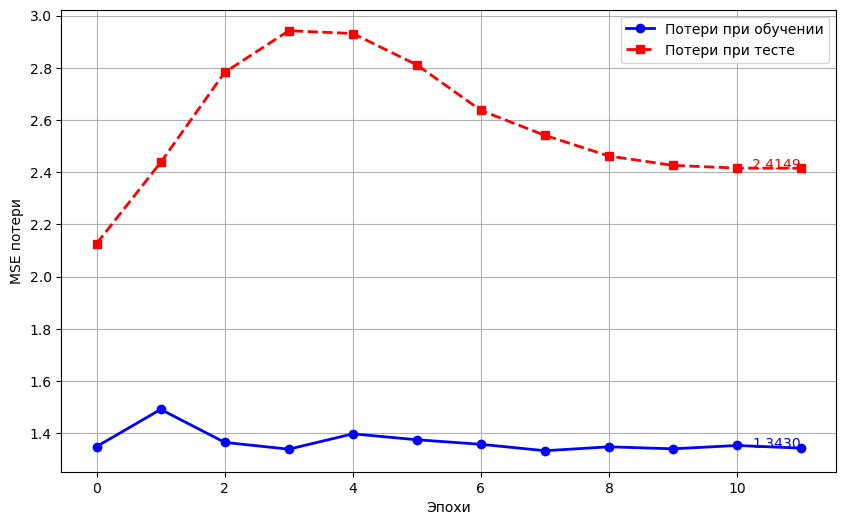

In [ ]:
user_ids_test = torch.tensor(test_data['userId'].values, dtype=torch.long)
movie_ids_test = torch.tensor(test_data['movieId'].values, dtype=torch.long) + num_users  # Смещаем movie IDs
edge_index_test = torch.stack([user_ids_test, movie_ids_test], dim=0)
edge_attr_test = torch.tensor(test_data['rating'].values, dtype=torch.float)
graph_data_test = Data(edge_index=edge_index_test, edge_attr=edge_attr_test, num_nodes=total_nodes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, min_lr=1e-6)
criterion = nn.MSELoss()
train_losses = []

def train():
    model.train()
    optimizer.zero_grad()
    out = model(graph_data)
    loss = criterion(out, graph_data.edge_attr)
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(graph_data_test)
        test_loss = criterion(out, graph_data_test.edge_attr)
    return test_loss.item()

num_epochs = 12
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    train_loss = train()
    train_losses.append(train_loss)

    test_loss = test()
    test_losses.append(test_loss)
    scheduler.step(test_loss)
    print(f'Эпоха {epoch+1}, Потери обучения: {train_loss:.4f}, Тестовые потери: {test_loss:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Потери при обучении', color='blue', marker='o', linestyle='-', linewidth=2, markersize=6)
plt.plot(test_losses, label='Потери при тесте', color='red', marker='s', linestyle='--', linewidth=2, markersize=6)
plt.xlabel('Эпохи')
plt.ylabel('MSE потери')
plt.grid(True)
plt.legend()
plt.text(len(train_losses)-1, train_losses[-1], f'{train_losses[-1]:.4f}', color='blue', ha='right')
plt.text(len(test_losses)-1, test_losses[-1], f'{test_losses[-1]:.4f}', color='red', ha='right')
plt.show()

In [ ]:
def calculate_rmse(model, graph_data_test):
    model.eval()
    with torch.no_grad():
        outputs_test = model(graph_data_test)
        predicted_ratings = outputs_test.squeeze().detach().numpy()
        actual_ratings = graph_data_test.edge_attr.numpy()
        rmse = np.sqrt(np.mean((predicted_ratings - actual_ratings) ** 2))
    return rmse
def get_predicted_ratings_for_user(model, user_id, num_movies, total_nodes):
    model.eval()
    user_ids = torch.tensor([user_id] * num_movies)
    movie_ids = torch.tensor(range(num_movies)) + num_users  # Смещаем movie IDs
    edge_index = torch.stack([user_ids, movie_ids], dim=0)

    graph_data_user = Data(edge_index=edge_index, num_nodes=total_nodes)
    with torch.no_grad():
        outputs = model(graph_data_user)
    predicted_ratings = outputs.squeeze().detach().numpy()
    return predicted_ratings

In [ ]:
def get_movie_recommendations(model, user_id, num_movies, total_nodes, movies_df):
    model.eval()
    user_ids = torch.tensor([user_id] * num_movies)
    movie_ids = torch.tensor(range(num_movies)) + num_users
    edge_index = torch.stack([user_ids, movie_ids], dim=0)

    graph_data_user = Data(edge_index=edge_index, num_nodes=total_nodes)
    with torch.no_grad():
        outputs = model(graph_data_user)
    predicted_ratings = outputs.squeeze().detach().numpy()

    # сортировка рейтингов
    recommended_movie_indices = np.argsort(predicted_ratings)[::-1]

    # названия фильмов по индексам
    recommended_movies = movies_df.iloc[recommended_movie_indices]


    recommended_movies['predicted_rating'] = predicted_ratings[recommended_movie_indices]
    return recommended_movies[['title', 'predicted_rating']]

movies_df = pd.read_csv('movie.csv')
test_rmse = calculate_rmse(model, graph_data_test)


user_id = 111
recommendations = get_movie_recommendations(model, user_id, num_movies, total_nodes, movies_df)

print("Test RMSE:", test_rmse)
print('\nРекомендованные фильмы для user_111:')
print(recommendations.head())

predicted_ratings_user_111 = get_predicted_ratings_for_user(model, user_id, num_movies, total_nodes)
print('\nПрогнозные оценки user_111 на все фильмы:')
print(predicted_ratings_user_111)

Test RMSE: 1.5540043

Рекомендованные фильмы для user_111:
                                          title  predicted_rating
10376                        Dirty Deeds (2005)          1.535980
13257  Tuya's Marriage (Tuya de hun shi) (2006)          1.516756
21734              America the Beautiful (2007)          1.504296
20745                       Alabama Moon (2009)          1.503651
2935                       Funhouse, The (1981)          1.496331

Прогнозные оценки user_111 на все фильмы:
[1.3299176 1.3214983 1.3563963 ... 1.3079542 1.3156854 1.3534335]
